In [52]:
import tensorflow as tf 
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt 

In [53]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [54]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "dataset",
   shuffle=True,
   image_size = (IMAGE_SIZE, IMAGE_SIZE),
   batch_size = BATCH_SIZE 
)

Found 1500 files belonging to 3 classes.


In [55]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [56]:
len(dataset)

47

In [57]:
type(dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [58]:
47*32

1504

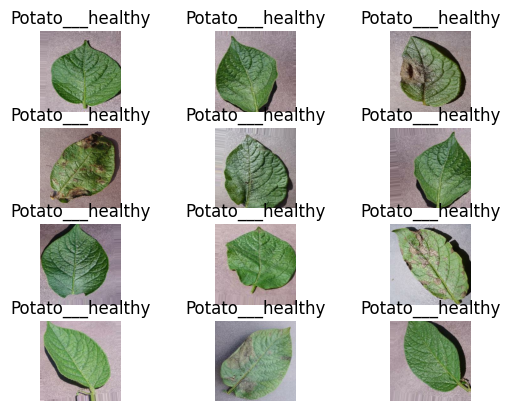

In [59]:
for img_batch, label_batch in dataset.take(1):
   for i in range(12):
      ax = plt.subplot(4, 3, i+1)
      plt.imshow(img_batch[i].numpy().astype("uint8"))
      plt.axis("off")
      plt.title(class_names[label_batch[0]])

In [60]:
len(dataset)

47

80% ->training <br> 
10% -> validation <br>
10% -> test 

In [61]:
train_size = 0.8
len(dataset)*train_size

37.6

In [62]:
dataset.take(37)
train_ds = dataset.take(37)

In [63]:
test_ds = dataset.skip(37)
len(test_ds)

10

In [64]:
val_size = 0.1
len(dataset)*val_size

4.7

In [65]:
val_ds = test_ds.take(4)
len(val_ds)

4

In [66]:
test_ds = test_ds.skip(4)
len(test_ds)

6

In [67]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
   assert (train_split + test_split + val_split) == 1
   ds_size = len(ds)
   
   if shuffle:
      ds = ds.shuffle(shuffle_size, seed=12)
   
   train_size = int(train_split * ds_size)
   val_size = int(val_split * ds_size)
   
   train_ds = ds.take(train_size)    
   val_ds = ds.skip(train_size).take(val_size)
   test_ds = ds.skip(train_size).skip(val_size)
   
   return train_ds, val_ds, test_ds

In [68]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [69]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

37
4
6


In [70]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [71]:
# resize_and_rescale = tf.keras.Sequential([
#    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#    layers.experimental.preprocessing.Rescaling(1.0/255)
# ])
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

Data Augmentation

In [72]:
datadata_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [75]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\yeduk\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [76]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

Compiling the model

In [77]:
model.compile(
   optimizer='adam',
   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
   metrics=['accuracy']
)

Training

In [78]:
history = model.fit(
   train_ds,
   batch_size=BATCH_SIZE,
   validation_data=val_ds,
   verbose=1,
   epochs=50,
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 38s 844ms/step - accuracy: 0.3604 - loss: 1.0936 - val_accuracy: 0.7891 - val_loss: 0.5642
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 760ms/step - accuracy: 0.7653 - loss: 0.5098 - val_accuracy: 0.7891 - val_loss: 0.5175
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 677ms/step - accuracy: 0.8459 - loss: 0.3904 - val_accuracy: 0.9062 - val_loss: 0.2524
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 698ms/step - accuracy: 0.8759 - loss: 0.2973 - val_accuracy: 0.8672 - val_loss: 0.3782
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 696ms/step - accuracy: 0.8738 - loss: 0.2967 - val_accuracy: 0.9219 - val_loss: 0.1947
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 694ms/step - accuracy: 0.9139 - loss: 0.2193 - val_accuracy: 0.9062 - val_loss: 0.2623
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 680ms/step - accuracy: 0.9033 - loss: 0.2480 - val_accuracy: 0.9141 - val_loss: 0.1753
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 750ms/step - accuracy: 0.9287 - loss: 0.1837 - val_accu

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

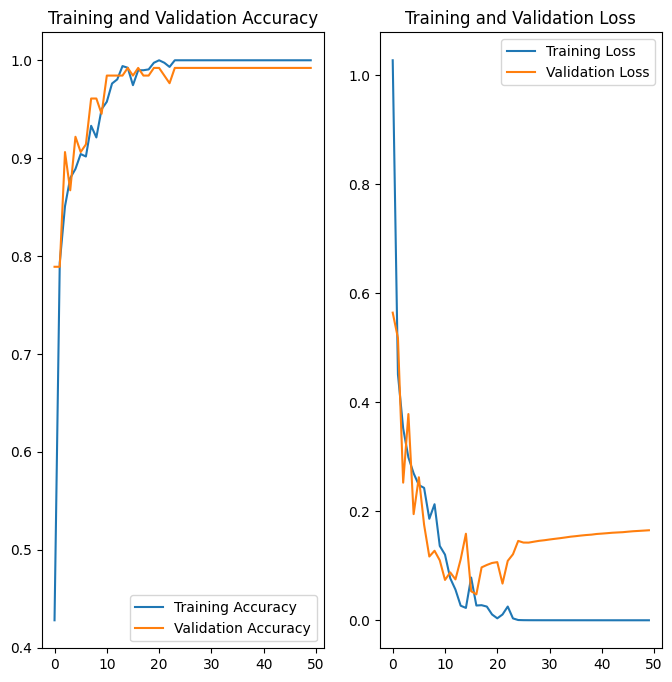

In [80]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
   first_image = images_batch[0].numpy().astype('uint8')
   first_label = labels_batch[0].numpy()
   
   print("first image to predict")
   # plt.imshow(first_image)
   print("actual label:",class_names[first_label])
   
   batch_prediction = model.predict(images_batch)
   print("predicted label:",class_names[np.argmax(batch_prediction[0])])



In [85]:
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [86]:
# Save the model using Pickle
import pickle 
with open("saved_steps.pkl", 'wb') as file:
   pickle.dump(model, file)